# Big cats CV recognition using PyTorch.
## Goals of this project:
### 1. Demonstrate PyTorch and visualization skills.
### 2. Train CNN without any pretrained models and show some result.
### 3. Try to enjoy this result.

## Data downloading and observing.
First of all let's import torch and check it's version.

In [1]:
import torch
from torch import nn
torch.__version__

'2.0.0'

We're going to use cuda on local machine, so let's code some device checking.

In [2]:
device =  'cuda' if torch.cuda.is_available() else'cpu'
device

'cuda'

I've saved folder of cats at main user's directory.

In [3]:
from pathlib import Path
image_path = Path('Cats/')


Using os.walk let's observe direcories and files and check what we have.

In [4]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print("There are {} directories and {} images in {}.". format(len(dirnames),len(filenames), dirpath))


In [5]:
walk_through_dir(image_path)

There are 3 directories and 3 images in Cats.
There are 10 directories and 0 images in Cats\test.
There are 0 directories and 5 images in Cats\test\AFRICAN LEOPARD.
There are 0 directories and 5 images in Cats\test\CARACAL.
There are 0 directories and 5 images in Cats\test\CHEETAH.
There are 0 directories and 5 images in Cats\test\CLOUDED LEOPARD.
There are 0 directories and 5 images in Cats\test\JAGUAR.
There are 0 directories and 5 images in Cats\test\LIONS.
There are 0 directories and 5 images in Cats\test\OCELOT.
There are 0 directories and 5 images in Cats\test\PUMA.
There are 0 directories and 5 images in Cats\test\SNOW LEOPARD.
There are 0 directories and 5 images in Cats\test\TIGER.
There are 10 directories and 0 images in Cats\train.
There are 0 directories and 236 images in Cats\train\AFRICAN LEOPARD.
There are 0 directories and 236 images in Cats\train\CARACAL.
There are 0 directories and 235 images in Cats\train\CHEETAH.
There are 0 directories and 229 images in Cats\train\

There is 50 valid images, 50 test images, and around 2300 - 2400 train images, classes are balanced. Now let's divide our data and load/show some images.

In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"
valid_dir = image_path / "valid"

train_dir, test_dir, valid_dir

(WindowsPath('Cats/train'),
 WindowsPath('Cats/test'),
 WindowsPath('Cats/valid'))

In [7]:
## 

Random image path:Cats\train\PUMA\071.jpg
Image class:PUMA
Image height: 224
Image width: 224


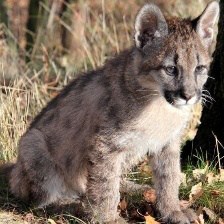

In [8]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))# glob function allow us to get access to every .jpg file 
#in /Cats directory with depth of 2 levels into main folder
random_image_path = random.choice(image_path_list)# chose random directory 
image_class = random_image_path.parent.stem # name of 1 level folder
img = Image.open(random_image_path)
print("Random image path:{}".format(random_image_path))
print("Image class:{}".format(image_class))
print("Image height: {}".format(img.height))
print("Image width: {}".format(img.width))
img

## Data check and transform

(-0.5, 223.5, 223.5, -0.5)

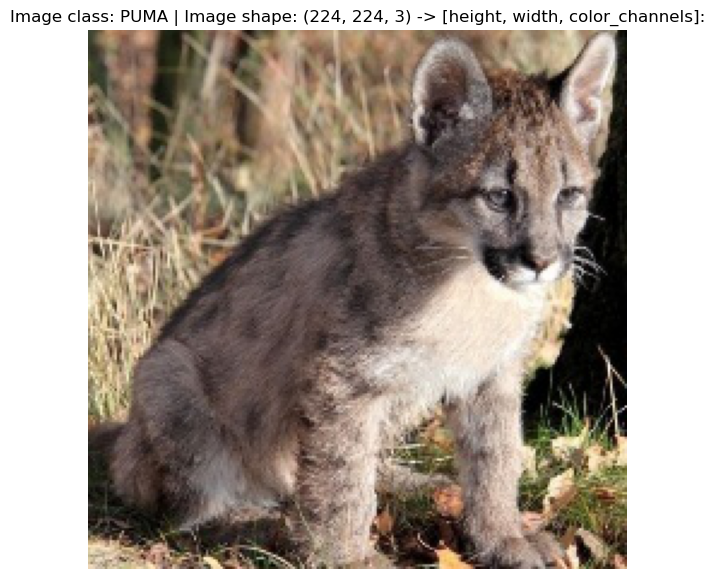

In [9]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)# convert image in NumPy array type of data

plt.figure(figsize = (10,7))
plt.imshow(img_as_array)
plt.title("Image class: {} | Image shape: {} -> [height, width, color_channels]:".format(image_class,img_as_array.shape ))
plt.axis('off') #print image using matplotlib and show np.array shape

Nice! We have got a sample image, printed it, transformed it in array and checked it's shape. Now, we're ready to work on data and prepare it to training.

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
    ]) 


Using torchvision.transforms diverse our data using horizontal flip, color changes or vertical flip can have bad influence on model and we don't change HW cause in description of data there is information that all pictures are 224 * 224 and last step: convert omage to torch.tensor format.

In [12]:
trans = data_transform(img)

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed = 23):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows = 1, ncols = 2)
            ax[0].imshow(f)
            ax[0].set_title('Original\nSize{}'.format(f.size))
            ax[0].axis('off')
            
            transformed_image = transform(f).permute(1,2,0) #mpl only accept HWC format, so we should reshape our tensor
            ax[1].imshow(transformed_image)
            ax[1].set_title('Transformed\nSize{}'.format(transformed_image.shape))
            ax[1].axis('off')
            
            fig.suptitle("Class:{}".format(image_path.parent.stem), fontsize=16)

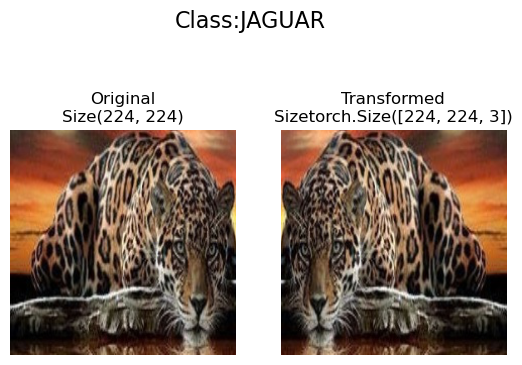

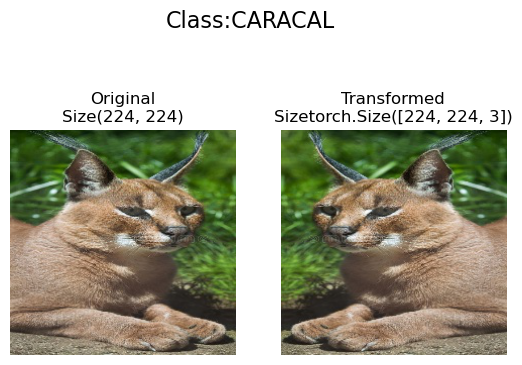

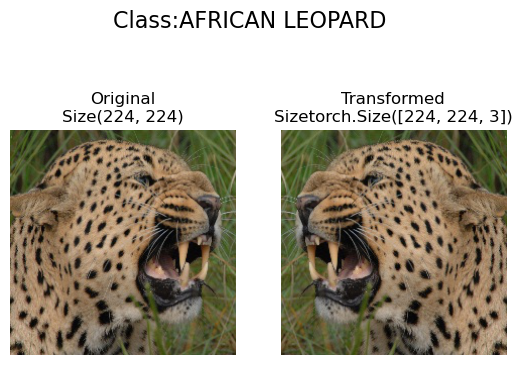

In [61]:
plot_transformed_images(image_path_list, data_transform)

Our transormer worked well, even with probability of 0.5 all of our 3 sample images are flipped, but that's ok. We can change random seed and see that it's not a mistake. Now let's apply our transformer on datasets using ImageFolder.

In [15]:
train_data = datasets.ImageFolder(root = train_dir,
                                 transform = data_transform)
test_data = datasets.ImageFolder(root = test_dir,
                                transform = data_transform)
valid_data = datasets.ImageFolder(root = valid_dir,
                                 transform = data_transform)

In [16]:
train_data, test_data, valid_data

(Dataset ImageFolder
     Number of datapoints: 2339
     Root location: Cats\train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 50
     Root location: Cats\test
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 50
     Root location: Cats\valid
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
class_names = train_data.classes
class_names

['AFRICAN LEOPARD',
 'CARACAL',
 'CHEETAH',
 'CLOUDED LEOPARD',
 'JAGUAR',
 'LIONS',
 'OCELOT',
 'PUMA',
 'SNOW LEOPARD',
 'TIGER']

In [18]:
class_dict = train_data.class_to_idx
class_dict

{'AFRICAN LEOPARD': 0,
 'CARACAL': 1,
 'CHEETAH': 2,
 'CLOUDED LEOPARD': 3,
 'JAGUAR': 4,
 'LIONS': 5,
 'OCELOT': 6,
 'PUMA': 7,
 'SNOW LEOPARD': 8,
 'TIGER': 9}

Saving class names and class dict will help us on model validation step. Now let's have some more observes.

In [19]:
len(train_data), len(test_data), len(valid_data)

(2339, 50, 50)

In [20]:
train_data.samples[0]

('Cats\\train\\AFRICAN LEOPARD\\001.jpg', 0)

In [21]:
train_data[0]

(tensor([[[0.8471, 0.8471, 0.8627,  ..., 0.1333, 0.0706, 0.0667],
          [0.8980, 0.8510, 0.8431,  ..., 0.1098, 0.0941, 0.0431],
          [0.0039, 0.9373, 0.8353,  ..., 0.0627, 0.1333, 0.0078],
          ...,
          [0.7647, 0.7882, 0.7686,  ..., 0.1412, 0.1804, 0.1608],
          [0.7686, 0.7608, 0.7804,  ..., 0.1255, 0.1647, 0.1490],
          [0.7608, 0.7686, 0.7725,  ..., 0.0863, 0.1216, 0.2039]],
 
         [[0.8510, 0.8510, 0.8667,  ..., 0.1373, 0.0745, 0.0706],
          [0.9020, 0.8549, 0.8471,  ..., 0.1137, 0.0980, 0.0471],
          [0.0078, 0.9412, 0.8392,  ..., 0.0627, 0.1373, 0.0118],
          ...,
          [0.7922, 0.8196, 0.7922,  ..., 0.1098, 0.1412, 0.1216],
          [0.7961, 0.7843, 0.7961,  ..., 0.0941, 0.1255, 0.1098],
          [0.7843, 0.7922, 0.7882,  ..., 0.0549, 0.0824, 0.1647]],
 
         [[0.8667, 0.8667, 0.8824,  ..., 0.1176, 0.0549, 0.0510],
          [0.9176, 0.8706, 0.8627,  ..., 0.0941, 0.0784, 0.0275],
          [0.0235, 0.9569, 0.8549,  ...,

In [22]:
img,label = train_data[0][0], train_data[0][1]

In [23]:
img,label

(tensor([[[0.8471, 0.8471, 0.8627,  ..., 0.1333, 0.0706, 0.0667],
          [0.8980, 0.8510, 0.8431,  ..., 0.1098, 0.0941, 0.0431],
          [0.0039, 0.9373, 0.8353,  ..., 0.0627, 0.1333, 0.0078],
          ...,
          [0.7647, 0.7882, 0.7686,  ..., 0.1412, 0.1804, 0.1608],
          [0.7686, 0.7608, 0.7804,  ..., 0.1255, 0.1647, 0.1490],
          [0.7608, 0.7686, 0.7725,  ..., 0.0863, 0.1216, 0.2039]],
 
         [[0.8510, 0.8510, 0.8667,  ..., 0.1373, 0.0745, 0.0706],
          [0.9020, 0.8549, 0.8471,  ..., 0.1137, 0.0980, 0.0471],
          [0.0078, 0.9412, 0.8392,  ..., 0.0627, 0.1373, 0.0118],
          ...,
          [0.7922, 0.8196, 0.7922,  ..., 0.1098, 0.1412, 0.1216],
          [0.7961, 0.7843, 0.7961,  ..., 0.0941, 0.1255, 0.1098],
          [0.7843, 0.7922, 0.7882,  ..., 0.0549, 0.0824, 0.1647]],
 
         [[0.8667, 0.8667, 0.8824,  ..., 0.1176, 0.0549, 0.0510],
          [0.9176, 0.8706, 0.8627,  ..., 0.0941, 0.0784, 0.0275],
          [0.0235, 0.9569, 0.8549,  ...,

In [24]:
img_permute = img.permute(1,2,0)

In [25]:
img_permute.shape

torch.Size([224, 224, 3])

Text(0.5, 1.0, 'AFRICAN LEOPARD')

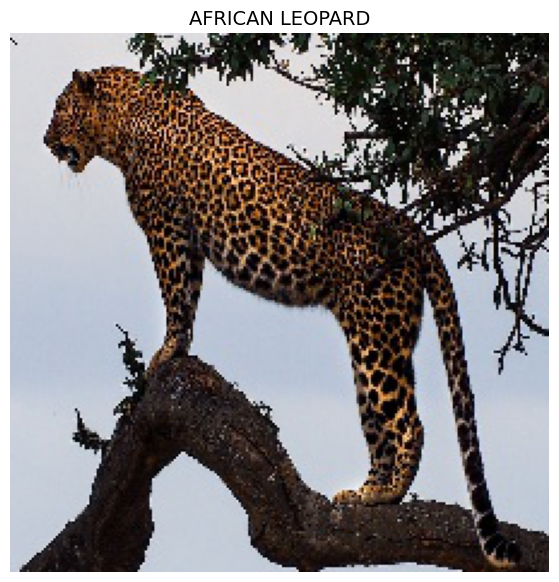

In [26]:
plt.figure(figsize =(10,7) )
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize = 14)

Allright, all of ours transfomes and ImgFolder did well. We have access to tensors, labels, and, visualy, our data is ok.

In [27]:
from torch.utils.data import DataLoader
BATCH_SIZE = 10 # images are pretty big, so we'll use batch_size of 10
train_dataloader = DataLoader(dataset = train_data,
                             batch_size = BATCH_SIZE,
                             num_workers = os.cpu_count(),
                              shuffle = True) # cause our data is oredered we want our model not to recognize this pattern
test_dataloader = DataLoader(dataset = test_data,
                            batch_size = BATCH_SIZE,
                            num_workers = os.cpu_count(),
                            shuffle = False)
valid_dataloader = DataLoader(dataset = valid_data,
                              batch_size = BATCH_SIZE,
                              num_workers = os.cpu_count())
train_dataloader, test_dataloader, valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x244996d5580>,
 <torch.utils.data.dataloader.DataLoader at 0x244996d5790>)

## Model training

First rule of all: don't underestimate linear regression, so let's try this out. 

In [62]:
class CatsDetectionModel(nn.Module):
    def __init__(self, input_shape:int,
                 output_shape:int,
                 number_neurons:int):
        super().__init__()#initiate super class
        self.layers = nn.Sequential(
        nn.Flatten(),#Convert our 3 dimensional tensor in 1-d
        nn.Linear(in_features = input_shape, out_features = number_neurons),
        nn.ReLU(), #ReLU for non-linearity
        nn.Linear(in_features = number_neurons, out_features = number_neurons),
        nn.ReLU(),
        nn.Linear(in_features = number_neurons, out_features = output_shape))
    def forward(self, x):
        return self.layers(x)
        

In [63]:
model_0 = CatsDetectionModel(3*224*224, len(class_names), 20)
model_0.to(device)

CatsDetectionModel(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=150528, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): ReLU()
    (5): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [64]:
dummy_x = torch.rand([1,3,224,224]).to(device) # before training out model let's check if we did good job on parameters

In [65]:
model_0(dummy_x)

tensor([[-0.1770,  0.1321, -0.0327,  0.0016, -0.0355,  0.0604,  0.1151,  0.0964,
         -0.0516, -0.2089]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [32]:
from helper_functions import accuracy_fn # we can use sclearn function, but in this case we'll use custom

In [66]:
loss_fn = torch.nn.CrossEntropyLoss()# crossnetropy for multiclass problem
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.01)# Stochastic gradient descent as optimizer

In [67]:
from timeit import default_timer as timer
def print_time_pass(start : float,
                   end:float,
                   device = None):
    """ 
    Simple function for calcualting time passed.
    """
    total_time = end - start
    print('Total time on {}: {:.3} seconds'.format(device, total_time))
    return total_time

In [68]:
from tqdm.auto import tqdm # TQDM for visualization of progress
torch.manual_seed(42)
train_time_start_on_gpu = timer()
epochs = 10# let's start with 10 epochs
for epoch in tqdm(range(epochs)):
    print('Epoch:{}\n-----'.format(epoch))
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):# enumerate dataloader for "for" cycle
        model_0.train()#activate train function to activate train mode
        X, y = X.to(device), y.to(device)#put our tensors to GPU
        y_pred = model_0(X)# get predictions 
        
        loss = loss_fn(y_pred, y)#calculate loss
        
        train_loss += loss#accumulate loss
        
        optimizer.zero_grad()# reset gradients of optimizer
        
        loss.backward()#update parameters of optimizer
        
        optimizer.step()#adjust parameters using learing rate
        if batch % 50 == 0:# print every 50th batch
            print("Looked at {}/{} samples".format(batch * len(X), len(train_dataloader.dataset)))
    train_loss /= len(train_dataloader)
    
    test_loss, test_acc = 0,0
    model_0.eval() #evaluate model
    with torch.inference_mode():#activate inference mode 
        for X_test, y_test in valid_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)           
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))
        test_loss /= len(valid_dataloader)
        test_acc /= len(valid_dataloader)
    print('Train loss{}| Test loss{}| Test acc{}'.format(train_loss, test_loss, test_acc))
train_time_end_on_gpu = timer()
print_time_pass(train_time_start_on_gpu, train_time_end_on_gpu, device = next(model_0.parameters()).device)#calculate time

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0
-----
Looked at 0/2339 samples
Looked at 500/2339 samples
Looked at 1000/2339 samples
Looked at 1500/2339 samples
Looked at 2000/2339 samples
Train loss2.3096821308135986| Test loss2.3055803775787354| Test acc12.0
Epoch:1
-----
Looked at 0/2339 samples
Looked at 500/2339 samples
Looked at 1000/2339 samples
Looked at 1500/2339 samples
Looked at 2000/2339 samples
Train loss2.3061909675598145| Test loss2.3043696880340576| Test acc10.0
Epoch:2
-----
Looked at 0/2339 samples
Looked at 500/2339 samples
Looked at 1000/2339 samples
Looked at 1500/2339 samples
Looked at 2000/2339 samples
Train loss2.3046200275421143| Test loss2.303560972213745| Test acc10.0
Epoch:3
-----
Looked at 0/2339 samples
Looked at 500/2339 samples
Looked at 1000/2339 samples
Looked at 1500/2339 samples
Looked at 2000/2339 samples
Train loss2.303934335708618| Test loss2.3031373023986816| Test acc10.0
Epoch:4
-----
Looked at 0/2339 samples
Looked at 500/2339 samples
Looked at 1000/2339 samples
Looked at 1500/2339 

264.2758180000001

10% of accuracy with 10 classes, seems like model predict random label... Let's automatise training and testing process and try another model.

In [36]:
torch.manual_seed(42)
def train_loop(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device: torch.device = device):
    train_loss = 0
    train_acc = 0
    for batch, (X, y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(device)
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        if batch % 50 == 0:
            print("Looked at {}/{} samples".format(batch * len(X), len(data_loader.dataset)))
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print("Train loss: {:.5} | Train accuracy: {:.5}".format(train_loss,
                                                       train_acc))
        
def valid_loop(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn,
             device: torch.device = device):
    test_loss = 0
    test_acc = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred, y)
            test_loss += loss
            acc = accuracy_fn(y, test_pred.argmax(dim=1))
            test_acc += acc
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print("Valid loss: {:.5} | Valid accuracy: {:.5}".format(test_loss, test_acc))
    
        

In [37]:
class CatsDetectionModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.nv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                 out_channels = hidden_units,
                  padding = 1,# add special items, that help to make edges of the image more visible for model
                  kernel_size = 3,# size of kernel (3,3)
                 stride = 1),# step size
        nn.ReLU(),
            nn.Dropout2d(p=0.1),#to reduce overfitting use dropout layer after each Convolutional layer
        nn.Conv2d(in_channels = hidden_units,
                 out_channels = hidden_units,
                 padding = 1,
                 stride = 1,
                 kernel_size = 3),
        nn.ReLU(),
            nn.Dropout2d(p=0.1),
        nn.MaxPool2d(kernel_size = 2)
        )# chose maximum feature in window of 2
        self.nv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, 
                 out_channels = hidden_units,
                 padding = 1,
                 stride = 1,
                 kernel_size = 3),
        nn.ReLU(),
            nn.Dropout2d(p=0.1),
        nn.Conv2d(in_channels = hidden_units,
                 out_channels = hidden_units,
                 stride = 1,
                 padding = 1,
                 kernel_size = 3),
        nn.ReLU(),
            nn.Dropout2d(p=0.1),
        nn.MaxPool2d(kernel_size = 2)
        )
        
        self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*3136,#this number comes from error mat1 * mat2, inner size of matrices should match 
                 out_features = output_shape)# 
        )
    def forward(self, x : torch.tensor):
        x = self.nv_block_1(x)
        
        x = self.nv_block_2(x)
        
        x = self.classifier(x)
        
        return x

In [38]:
rand_img_tensor = torch.rand(size  = (3,224,224)).unsqueeze(0)
rand_img_tensor.shape #create dummy image to test our model

torch.Size([1, 3, 224, 224])

In [39]:
torch.manual_seed(42)
model_1 = CatsDetectionModelV1(input_shape = 3,
                             hidden_units = 10,
                             output_shape = 10).to(device)
model_1(rand_img_tensor.to(device))

tensor([[ 0.0607,  0.0558, -0.0441, -0.0487,  0.0584, -0.0209,  0.0260, -0.0572,
          0.0765, -0.0229]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [40]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                            lr = 0.001)

In [41]:
torch.manual_seed(42)
from tqdm.auto import tqdm 
# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loop(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    valid_loop(data_loader=valid_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_time_pass(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/2339 samples
Looked at 500/2339 samples
Looked at 1000/2339 samples
Looked at 1500/2339 samples
Looked at 2000/2339 samples
Train loss: 2.3398 | Train accuracy: 10.0
Valid loss: 2.3022 | Valid accuracy: 10.0
Epoch: 1
---------
Looked at 0/2339 samples
Looked at 500/2339 samples
Looked at 1000/2339 samples
Looked at 1500/2339 samples
Looked at 2000/2339 samples
Train loss: 2.3025 | Train accuracy: 10.774
Valid loss: 2.2949 | Valid accuracy: 14.0
Epoch: 2
---------
Looked at 0/2339 samples
Looked at 500/2339 samples
Looked at 1000/2339 samples
Looked at 1500/2339 samples
Looked at 2000/2339 samples
Train loss: 2.2954 | Train accuracy: 10.432
Valid loss: 2.2531 | Valid accuracy: 6.0
Epoch: 3
---------
Looked at 0/2339 samples
Looked at 500/2339 samples
Looked at 1000/2339 samples
Looked at 1500/2339 samples
Looked at 2000/2339 samples
Train loss: 2.2026 | Train accuracy: 17.445
Valid loss: 2.0347 | Valid accuracy: 14.0
Epoch: 4
---------
Looked at 0/2339 sam

Allright, we get SOME result, our model found patterns and shows robust 30-40% valid accuracy, thats really low TBH, but it's model from scratch and it's way better than dummy model. Now, let's look at our test accuracy and visualize what what we get.

In [47]:
y_preds = []
model_1.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
        X, y = X.to(device), y.to(device)
    # Do the forward pass
        y_logit = model_1(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/5 [00:00<?, ?it/s]

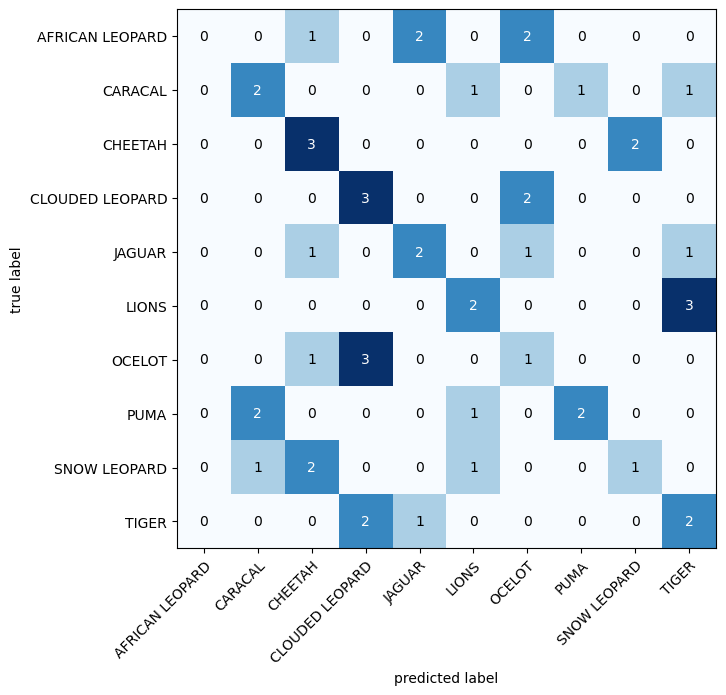

In [48]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

#Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_data.targets))

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [49]:
loss, acc = 0, 0
model_1.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        # Send data to the target device
        X, y = X.to(device), y.to(device)
        y_pred = model_1(X)
        loss += loss_fn(y_pred, y)
        acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale loss and acc
    loss /= len(test_dataloader)
    acc /= len(test_dataloader)
print('Model test loss {:.2}| Model test accuracy:{}'.format(loss, acc))

Model test loss 2.2| Model test accuracy:40.0


As we see, our model is definitely not random, but missmatches lions and tigers, can't detect african leopard(like i can), relativetely good at detecting cheetahs and clouded leopards. Test accuracy is 40 % as valid when we stoped training our model.
</br>Problems that we've faced during training:
1. overfitting: training accuracy goes to 100%  after 8 epochs without dropout layer, but valid accuracy around 20-30.
2. small amount of valid and test images: 2339 vs 50 vs 50
3. device is nvidia mx330, so we are limited in epochs and tries. 

## Fun
Now let's download random image from internet and try our model.

In [50]:
custom_image_path = Path('cat2.jfif') 

In [51]:
import torchvision

# Read in custom image
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[ 70.,  71.,  71.,  ...,  65.,  67.,  68.],
         [ 70.,  69.,  70.,  ...,  63.,  65.,  66.],
         [ 67.,  68.,  69.,  ...,  64.,  64.,  65.],
         ...,
         [ 44.,  43.,  42.,  ..., 164., 162., 156.],
         [ 44.,  42.,  41.,  ..., 171., 170., 165.],
         [ 40.,  42.,  44.,  ..., 171., 172., 168.]],

        [[ 35.,  36.,  39.,  ...,  33.,  35.,  36.],
         [ 35.,  37.,  38.,  ...,  31.,  33.,  34.],
         [ 35.,  36.,  37.,  ...,  32.,  32.,  33.],
         ...,
         [ 25.,  24.,  23.,  ..., 104.,  99.,  93.],
         [ 25.,  23.,  22.,  ..., 107., 106., 101.],
         [ 21.,  23.,  25.,  ..., 108., 107., 103.]],

        [[ 13.,  14.,  16.,  ...,  20.,  22.,  23.],
         [ 13.,  14.,  15.,  ...,  18.,  20.,  21.],
         [ 12.,  13.,  14.,  ...,  19.,  19.,  20.],
         ...,
         [ 11.,  10.,   9.,  ...,  70.,  66.,  60.],
         [ 11.,   9.,   8.,  ...,  72.,  71.,  66.],
         [  7.,   9.,  11.,  ...

In [52]:
custom_image = custom_image / 255. # our model used tensors with variety from 0 to 1, so just divide our data by 255

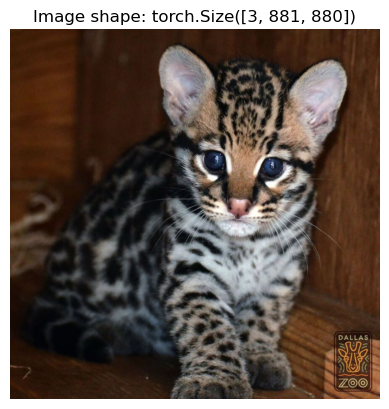

In [53]:
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [54]:
custom_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
])#resahpe our image to original trained format

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 881, 880])
New shape: torch.Size([3, 224, 224])


C:\Users\VovAz\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [55]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 224, 224])
Unsqueezed custom image shape: torch.Size([1, 3, 224, 224])


In [56]:
custom_image_pred

tensor([[-19.5416, -21.3194, -17.0053, -11.5892, -14.6235, -21.1347,  -8.9909,
         -24.6153, -20.0626, -11.3963]], device='cuda:0')

In [57]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-19.5416, -21.3194, -17.0053, -11.5892, -14.6235, -21.1347,  -8.9909,
         -24.6153, -20.0626, -11.3963]], device='cuda:0')
Prediction probabilities: tensor([[2.2400e-05, 3.7859e-06, 2.8296e-04, 6.3667e-02, 3.0630e-03, 4.5536e-06,
         8.5573e-01, 1.4020e-07, 1.3303e-05, 7.7213e-02]], device='cuda:0')
Prediction label: tensor([6], device='cuda:0')


In [58]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'OCELOT'

WOW!Our model on test data predicted 1 of 5 ocelots, but worked good on random internet image. Or was it just coincidence?